In [9]:
import numpy as np
import scipy.stats as stats
import pandas as pd

def classify_distribution0(data, dist_names=None, top_n=3, verbose=False):
    """
    Test input data against a list of probability distributions and classify the best fits.

    Parameters:
    - data (array-like): Input numerical data.
    - dist_names (list): List of scipy.stats distribution names to test. If None, uses a default list.
    - top_n (int): Number of top distributions to return.
    - verbose (bool): If True, prints intermediate results.

    Returns:
    - pd.DataFrame: A DataFrame with the best-fitting distributions ranked by KS test statistic.
    """

    # Ensure data is a clean 1D array
    data = np.asarray(data)
    data = data[np.isfinite(data)]

    # Common continuous distributions to test
    if dist_names is None:
        dist_names = [
            'norm', 'expon', 'uniform', 'lognorm', 'gamma', 'beta',
            'weibull_min', 'weibull_max', 'pareto', 'triang'
        ]

    results = []

    for dist_name in dist_names:
        dist = getattr(stats, dist_name)
        try:
            # Fit distribution to data
            params = dist.fit(data)
            # Perform the KS test
            D, p = stats.kstest(data, dist_name, args=params)
            results.append({
                'Distribution': dist_name,
                'KS_Statistic': D,
                'p_value': p,
                'Parameters': params
            })
            if verbose:
                print(f"{dist_name}: KS={D:.4f}, p={p:.4f}, params={params}")
        except Exception as e:
            if verbose:
                print(f"{dist_name} fitting failed: {e}")

    # Sort by lowest KS statistic (best fit)
    results_df = pd.DataFrame(results).sort_values(by='KS_Statistic')
    return results_df.head(top_n)


In [10]:
import numpy as np
import scipy.stats as stats
import warnings

def classify_distribution1(data, distributions=None, criterion='aic'):
    """
    Classify the input data into the best-fitting distribution.

    Parameters:
        data (array-like): Input data to classify.
        distributions (list): List of scipy.stats distributions to test. If None, uses a default list.
        criterion (str): Criterion for selection ('ks' for Kolmogorov-Smirnov, 'aic' for Akaike Information Criterion).

    Returns:
        dict: Best fitting distribution and statistics for all tested distributions.
    """
    if distributions is None:
        distributions = ['norm', 'expon', 'lognorm', 'gamma', 'weibull_min', 'weibull_max', 'beta']

    results = []
    data = np.asarray(data)
    data = data[~np.isnan(data)]  # Remove NaNs

    for dist_name in distributions:
        try:
            dist = getattr(stats, dist_name)
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                params = dist.fit(data)
                ks_stat, ks_p = stats.kstest(data, dist_name, args=params)
                log_likelihood = np.sum(dist.logpdf(data, *params))
                k = len(params)
                aic = 2 * k - 2 * log_likelihood
                results.append({
                    'distribution': dist_name,
                    'params': params,
                    'ks_stat': ks_stat,
                    'ks_p': ks_p,
                    'aic': aic
                })
        except Exception as e:
            continue  # Skip distributions that fail

    if criterion == 'ks':
        best = min(results, key=lambda x: x['ks_stat'])
    elif criterion == 'aic':
        best = min(results, key=lambda x: x['aic'])
    else:
        raise ValueError("Criterion must be 'ks' or 'aic'.")

    return {
        'best_fit': best,
        'all_results': sorted(results, key=lambda x: x[criterion if criterion == 'aic' else 'ks_stat'])
    }


In [11]:
import numpy as np
import scipy.stats as stats
import warnings

def classify_distribution2(data, distributions=None, criterion='aic'):
    """
    Classify the input data into the best-fitting distribution.

    Parameters:
        data (array-like): Input numeric data.
        distributions (list): List of distribution names (from scipy.stats) to test. Defaults to common continuous ones.
        criterion (str): Model selection criterion: 'aic' (default) or 'ks'.

    Returns:
        dict: {
            'best_fit': dict of best distribution and its stats,
            'all_results': list of results for all tested distributions
        }
    """
    if distributions is None:
        distributions = [
            'norm', 'expon', 'lognorm', 'gamma', 
            'weibull_min', 'weibull_max', 'beta', 'uniform'
        ]

    data = np.asarray(data)
    data = data[~np.isnan(data)]  # Remove NaNs

    results = []

    for dist_name in distributions:
        try:
            dist = getattr(stats, dist_name)
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                # Fit distribution to data
                params = dist.fit(data)
                # Kolmogorov-Smirnov test
                ks_stat, ks_p = stats.kstest(data, dist_name, args=params)
                # Log-likelihood for AIC
                log_likelihood = np.sum(dist.logpdf(data, *params))
                k = len(params)
                aic = 2 * k - 2 * log_likelihood

                results.append({
                    'distribution': dist_name,
                    'params': params,
                    'ks_stat': ks_stat,
                    'ks_p': ks_p,
                    'aic': aic
                })
        except Exception:
            continue  # Ignore errors from incompatible fits

    if not results:
        raise RuntimeError("No distribution fits were successful.")

    if criterion == 'ks':
        best = min(results, key=lambda x: x['ks_stat'])
    elif criterion == 'aic':
        best = min(results, key=lambda x: x['aic'])
    else:
        raise ValueError("Criterion must be either 'aic' or 'ks'.")

    return {
        'best_fit': best,
        'all_results': sorted(results, key=lambda x: x[criterion if criterion == 'aic' else 'ks_stat'])
    }


In [12]:
def classify_distribution3(data, dist_names=None, top_n=3, verbose=False):
    data = np.asarray(data)
    data = data[np.isfinite(data)]

    if data.size == 0:
        raise ValueError("Input data must contain at least one finite number.")

    if dist_names is None:
        dist_names = [
            'norm', 'expon', 'uniform', 'lognorm', 'gamma', 'beta',
            'weibull_min', 'weibull_max', 'pareto', 'triang'
        ]

    results = []

    for dist_name in dist_names:
        dist = getattr(stats, dist_name)
        try:
            params = dist.fit(data)
            D, p = stats.kstest(data, dist_name, args=params)
            results.append({
                'Distribution': dist_name,
                'KS_Statistic': D,
                'p_value': p,
                'Parameters': params
            })
            if verbose:
                print(f"{dist_name}: KS={D:.4f}, p={p:.4f}, params={params}")
        except Exception as e:
            if verbose:
                print(f"{dist_name} fitting failed: {e}")

    if not results:
        raise RuntimeError("No distributions could be fitted to the input data.")

    results_df = pd.DataFrame(results).sort_values(by='KS_Statistic')
    return results_df.head(top_n)


In [19]:
# Simulate data from a uniform distribution
data = np.random.uniform(0, 1, 1000)

try:
    # Classify which distribution fits best
    result0 = classify_distribution0(data)
    # Print result
    print("Best fitting distribution:", result0.iloc[0]["Distribution"])
    print("Parameters:", result0.iloc[0]["Parameters"])
except:
    print(f"result0: {result0}")

try:
    print("-"*50)
    # Classify which distribution fits best
    result1 = classify_distribution1(data)
    # Print result
    print("Best fitting distribution:", result1['best_fit']['distribution'])
    print("Parameters:", result1['best_fit']['params'])
except:
    print(f"result1: {result1}")

try:
    print("-"*50)
    # Classify which distribution fits best
    result2 = classify_distribution2(data)
    # Print result
    print("Best fitting distribution:", result2['best_fit']['distribution'])
    print("Parameters:", result2['best_fit']['params'])
except:
    print(f"result2: {result2}")

try:
    print("-"*50)
    # Classify which distribution fits best
    result3 = classify_distribution0(data)
    # Print result
    print("Best fitting distribution:", result3.iloc[0]["Distribution"])
    print("Parameters:", result3.iloc[0]["Parameters"])
except:
    print(f"result3: {result3}")

Best fitting distribution: beta
Parameters: (0.976776755261995, 0.9741969057641351, 0.0007619822239925965, 1.0005742574965382)
--------------------------------------------------
Best fitting distribution: beta
Parameters: (0.976776755261995, 0.9741969057641351, 0.0007619822239925965, 1.0005742574965382)
--------------------------------------------------
Best fitting distribution: uniform
Parameters: (0.0007619822239925966, 0.9991203033479208)
--------------------------------------------------
Best fitting distribution: beta
Parameters: (0.976776755261995, 0.9741969057641351, 0.0007619822239925965, 1.0005742574965382)


Best fit distribution: weibull_min
Parameters: (1.4312106190744904, 0.050007011417103966, 0.9236015733703349)


/Users/tako/codes/miniconda3/envs/foo310/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:709: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Users/tako/codes/miniconda3/envs/foo310/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


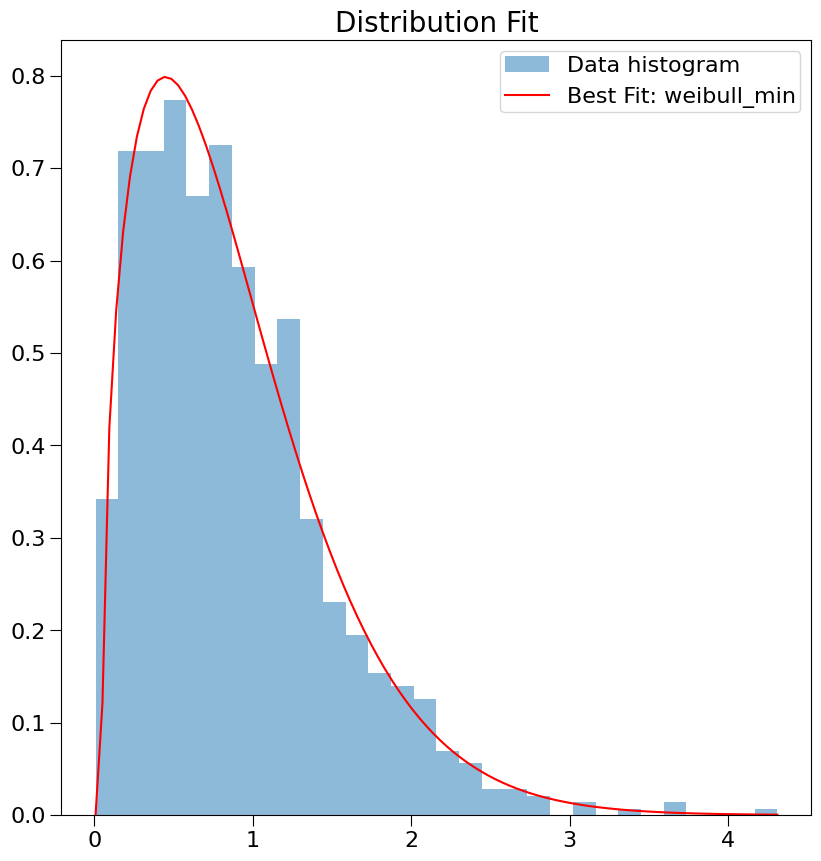

In [14]:
import matplotlib.pyplot as plt

# Generate example data
data = np.random.weibull(1.5, 1000)

# Classify distribution
result0 = classify_distribution0(data)

# Print result0
print("Best fit distribution:", result0.iloc[0]["Distribution"])
print("Parameters:", result0.iloc[0]["Parameters"])

# Optional: Plot histogram and fitted PDF
best_dist = getattr(stats, result0.iloc[0]["Distribution"])
params = result0.iloc[0]["Parameters"]
x = np.linspace(min(data), max(data), 100)
pdf_fitted = best_dist.pdf(x, *params)

plt.hist(data, bins=30, density=True, alpha=0.5, label='Data histogram')
plt.plot(x, pdf_fitted, 'r-', label=f'Best Fit: {result0.iloc[0]["Distribution"]}')
plt.legend()
plt.title("Distribution Fit")
plt.show()


Best fit distribution: beta
Parameters: (1.5719259041939373, 7.611981407934892, 0.003912077137792892, 5.309901914520875)


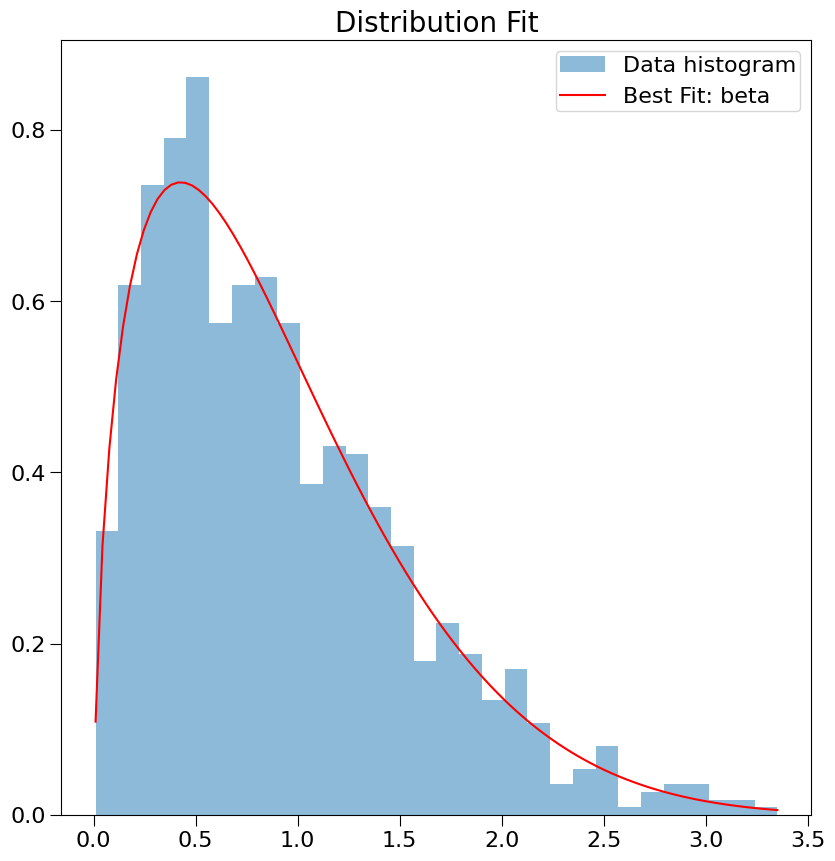

In [15]:
import matplotlib.pyplot as plt

# Generate example data
data = np.random.weibull(1.5, 1000)

# Classify distribution
result1 = classify_distribution1(data)

# Print result1
print("Best fit distribution:", result1['best_fit']['distribution'])
print("Parameters:", result1['best_fit']['params'])

# Optional: Plot histogram and fitted PDF
best_dist = getattr(stats, result1['best_fit']['distribution'])
params = result1['best_fit']['params']
x = np.linspace(min(data), max(data), 100)
pdf_fitted = best_dist.pdf(x, *params)

plt.hist(data, bins=30, density=True, alpha=0.5, label='Data histogram')
plt.plot(x, pdf_fitted, 'r-', label=f"Best Fit: {result1['best_fit']['distribution']}")
plt.legend()
plt.title("Distribution Fit")
plt.show()


Best fit distribution: weibull_min
Parameters: (1.431389669097082, 0.00033499512338609283, 1.0157395684313841)


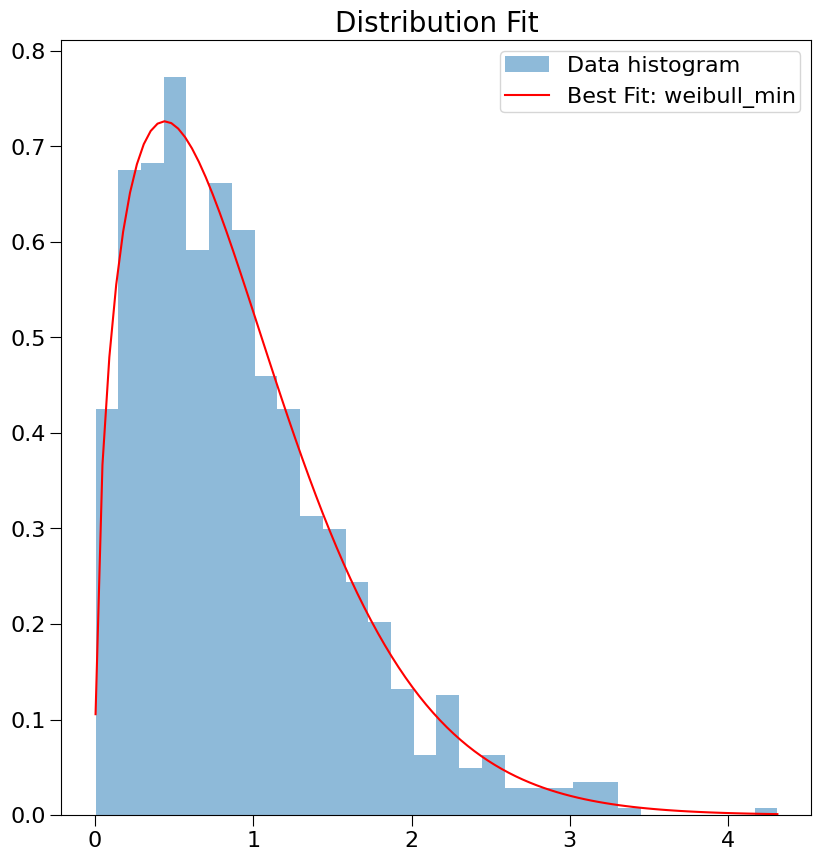

In [16]:
import matplotlib.pyplot as plt

# Generate example data
data = np.random.weibull(1.5, 1000)

# Classify distribution
result2 = classify_distribution2(data)

# Print result2
print("Best fit distribution:", result2['best_fit']['distribution'])
print("Parameters:", result2['best_fit']['params'])

# Optional: Plot histogram and fitted PDF
best_dist = getattr(stats, result2['best_fit']['distribution'])
params = result2['best_fit']['params']
x = np.linspace(min(data), max(data), 100)
pdf_fitted = best_dist.pdf(x, *params)

plt.hist(data, bins=30, density=True, alpha=0.5, label='Data histogram')
plt.plot(x, pdf_fitted, 'r-', label=f"Best Fit: {result2['best_fit']['distribution']}")
plt.legend()
plt.title("Distribution Fit")
plt.show()


Best fit distribution: weibull_min
Parameters: (1.4455815928428346, 0.0040824326936649185, 1.0026500452468061)


/Users/tako/codes/miniconda3/envs/foo310/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:709: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)


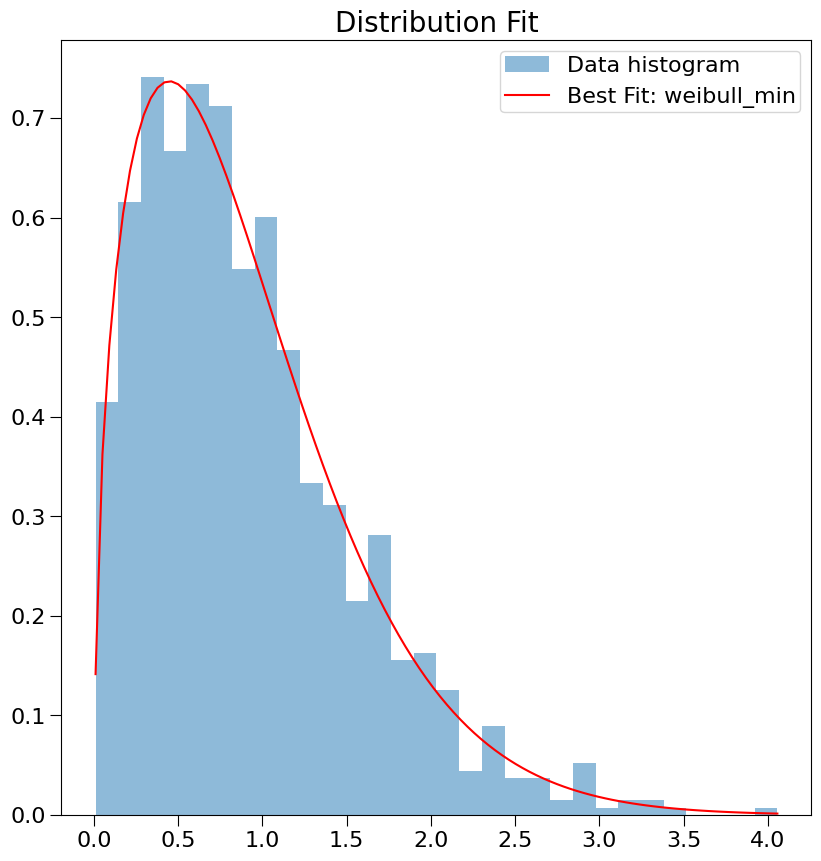

In [17]:
import matplotlib.pyplot as plt

# Generate example data
data = np.random.weibull(1.5, 1000)

# Classify distribution
result3 = classify_distribution3(data)

# Print result3
print("Best fit distribution:", result3.iloc[0]["Distribution"])
print("Parameters:", result3.iloc[0]["Parameters"])

# Optional: Plot histogram and fitted PDF
best_dist = getattr(stats, result3.iloc[0]["Distribution"])
params = result3.iloc[0]["Parameters"]
x = np.linspace(min(data), max(data), 100)
pdf_fitted = best_dist.pdf(x, *params)

plt.hist(data, bins=30, density=True, alpha=0.5, label='Data histogram')
plt.plot(x, pdf_fitted, 'r-', label=f'Best Fit: {result3.iloc[0]["Distribution"]}')
plt.legend()
plt.title("Distribution Fit")
plt.show()
